# Alzhiemers exploration

load data

In [2]:
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np


check features

In [3]:
dataset = load_dataset("Falah/Alzheimer_MRI")
print(dataset)

label_names = dataset['train'].features['label'].names
print("Class names:", label_names)  # ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

# Class distribution
train_labels = dataset['train']['label']
print("Train label distribution:", Counter(train_labels))


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5120
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
})
Class names: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Train label distribution: Counter({2: 2566, 3: 1781, 0: 724, 1: 49})


## Plot images

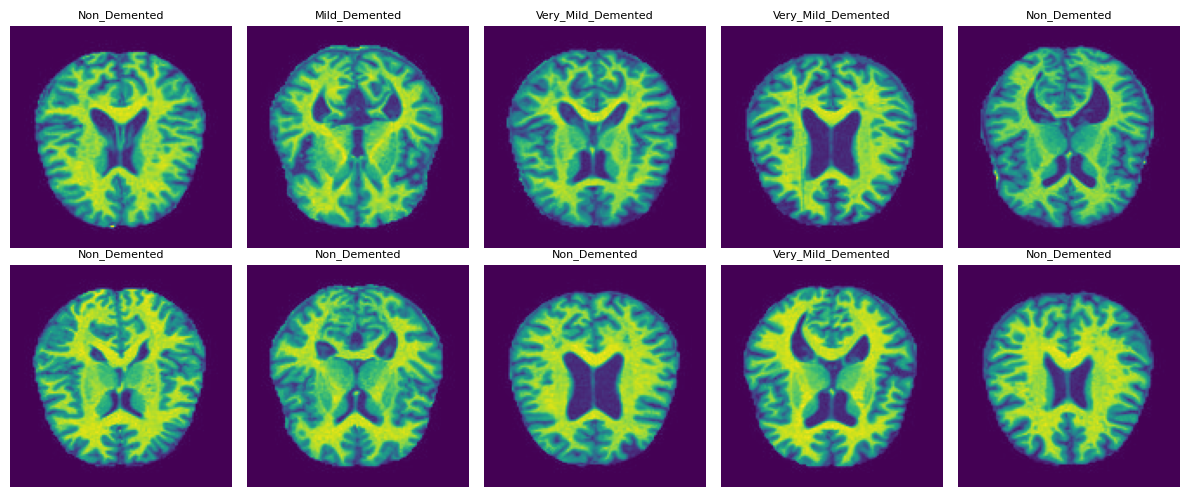

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flatten()):
    img = dataset['train'][i]['image']
    label = dataset['train'][i]['label']
    ax.imshow(img, cmap= 'viridis')
    ax.set_title(dataset['train'].features['label'].names[label], fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

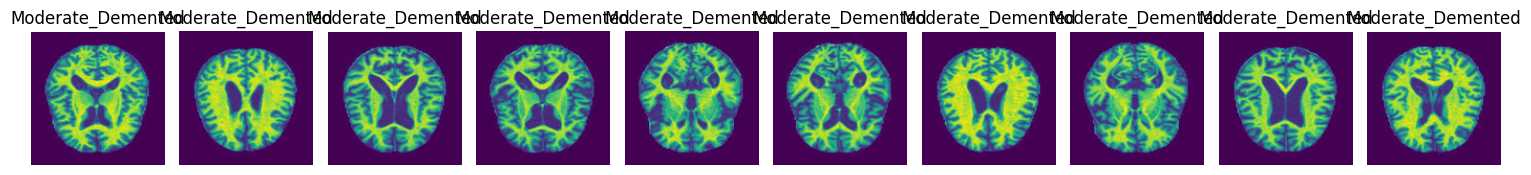

In [5]:
import matplotlib.pyplot as plt

def show_class_samples(dataset, class_name, n=10):
    label_names = dataset['train'].features['label'].names
    class_idx = label_names.index(class_name)

    # Find indices of images for this class
    indices = [i for i, l in enumerate(dataset['train']['label']) if l == class_idx][:n]

    # Plot images
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for ax, idx in zip(axes, indices):
        img = dataset['train'][idx]['image']
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(class_name)
    plt.tight_layout()
    plt.show()

#Class names: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
# Example: Show 10 "Moderate Demented" images
show_class_samples(dataset, "Moderate_Demented", n=10)


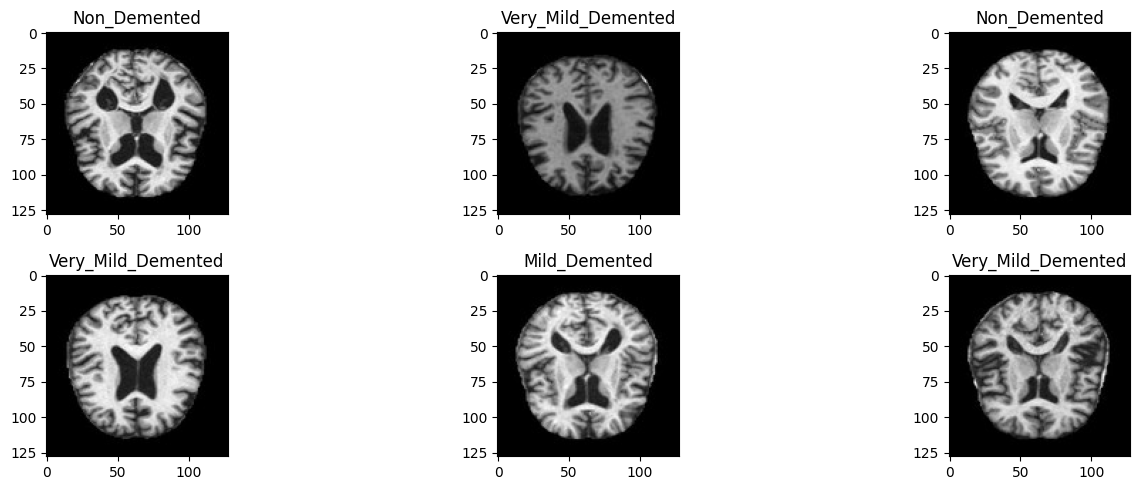

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
axs = ax.flatten()

for axes in axs:
    rand = np.random.randint(0, len(dataset['train']))
    img = dataset['train'][rand]['image']
    label = dataset['train'][rand]['label']

    axes.imshow(img, cmap="gray")  # show in grayscale
    axes.set_title(label_names[label])  # use label names

plt.tight_layout()
plt.show()

In [7]:
img = dataset['train'][0]['image']
print(f"Image size: {img.size}, Mode: {img.mode}")

sample_images = np.stack([np.array(dataset['train'][i]['image']) for i in range(100)])
print("Mean pixel value:", sample_images.mean(), "Std:", sample_images.std())

Image size: (128, 128), Mode: L
Mean pixel value: 70.91984436035156 Std: 83.35924606216709


In [8]:
import tensorflow as tf
import numpy as np

# target size for images useful for CNN
IMG_SIZE = (224, 224)
#img per batch for trainign
BATCH_SIZE = 32

def preprocess_image(img):
    # 3 channels
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize(IMG_SIZE)
    img = np.array(img) / 255.0
    return img.astype(np.float32)

def hf_to_tf_dataset(hf_dataset, batch_size=BATCH_SIZE):
    def generator():    #pairs img,label one at a time
        for example in hf_dataset:
            yield preprocess_image(example["image"]), example["label"]   #processes img and keeps label as is

    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=(  #descibes shape and data type of the generator
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    ds = ds.map(lambda x, y: (x, tf.one_hot(y, depth=len(label_names))))  #one hot encoder
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)  #groups data inot batches of 32 and enables background prefetching

# Create train/test datasets
train_ds = hf_to_tf_dataset(dataset["train"])
test_ds  = hf_to_tf_dataset(dataset["test"])


2025-07-24 20:34:57.971236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 20:34:57.987470: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 20:34:58.086396: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 20:34:58.178392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753385698.277930  549881 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753385698.29

In [9]:
for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape)
    print("Label shape:", labels.shape)


Batch shape: (32, 224, 224, 3)
Label shape: (32, 4)


2025-07-24 20:35:05.830090: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


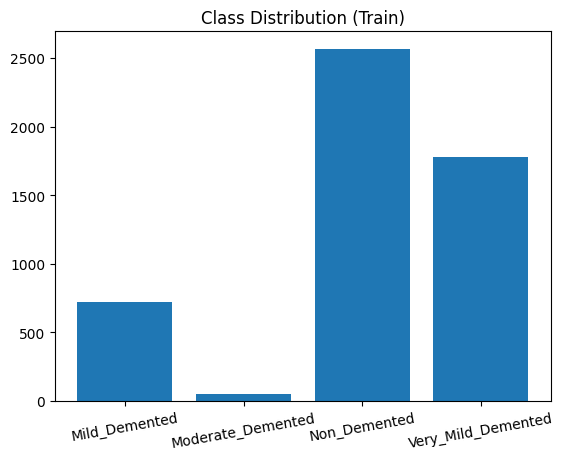

Train counts: Counter({2: 2566, 3: 1781, 0: 724, 1: 49})
Test counts: Counter({2: 634, 3: 459, 0: 172, 1: 15})


In [10]:
from collections import Counter
import matplotlib.pyplot as plt

train_counts = Counter(dataset['train']['label'])
test_counts  = Counter(dataset['test']['label'])
labels = dataset['train'].features['label'].names

plt.bar(labels, [train_counts[i] for i in range(len(labels))])
plt.title("Class Distribution (Train)")
plt.xticks(rotation=10)
plt.show()

print("Train counts:", train_counts)
print("Test counts:", test_counts)


### big class imbalance  moderate D only has 49 samples , must use class weights (below)

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array(dataset['train']['label'])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
print("Class weights:", dict(enumerate(class_weights)))


Class weights: {0: np.float64(1.7679558011049723), 1: np.float64(26.122448979591837), 2: np.float64(0.49883086515978176), 3: np.float64(0.7186973610331274)}


In [12]:
sizes = [dataset['train'][i]['image'].size for i in range(200)]
print("Unique sizes in first 200 images:", set(sizes))

modes = [dataset['train'][i]['image'].mode for i in range(200)]
print("Image modes (color channels):", set(modes))


Unique sizes in first 200 images: {(128, 128)}
Image modes (color channels): {'L'}


### all images are 128,128 and greyscale --> need to convert to rbg  for cnn

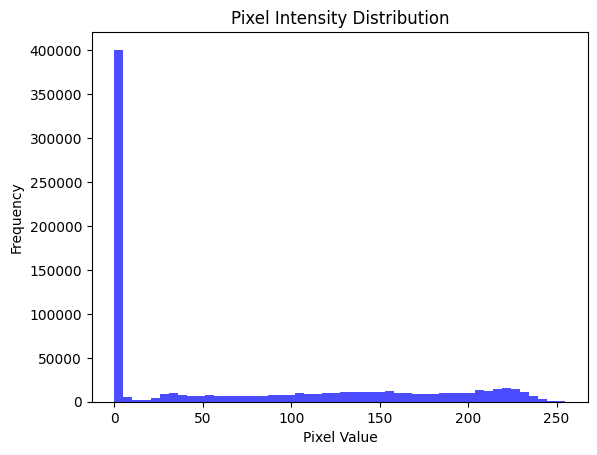

Pixel mean: 71.351083984375 std: 83.69291193174031


In [13]:
import numpy as np

sample_pixels = np.concatenate(
    [np.array(dataset['train'][i]['image']).ravel() for i in range(50)]
)
plt.hist(sample_pixels, bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

print("Pixel mean:", sample_pixels.mean(), "std:", sample_pixels.std())


### Mean 71, Std 83, with a big spike at 0 (black background) normalisation to [0, 1] (dividing by 255) needed

### converted to rbg to be compatible for later processing with cnn

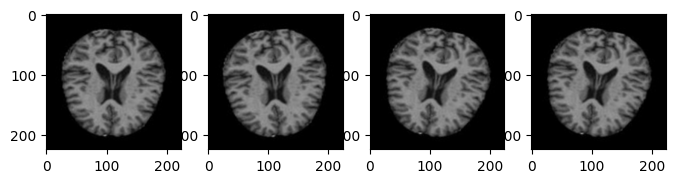

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Convert grayscale to RGB
img = dataset['train'][0]['image'].convert("RGB").resize((224, 224))
x = np.array(img, dtype=np.float32) / 255.0
x = np.expand_dims(x, axis=0)  # (1, 224, 224, 3)

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15, horizontal_flip=True)
it = datagen.flow(x, batch_size=1)

# Plot augmented images
plt.figure(figsize=(8, 4))
for i in range(4):
    batch = next(it)[0]
    plt.subplot(1, 4, i + 1)
    plt.imshow(batch)
    #plt.axis('off')
plt.show()

#below is the same image 4 times


In [15]:
print(np.array(img).shape)


(224, 224, 3)


### non-dem scans are slightly brighter, subtle though

In [16]:
for i, label in enumerate(labels):
    indices = [idx for idx, l in enumerate(dataset['train']['label']) if l == i]
    avg_intensity = np.mean([np.array(dataset['train'][idx]['image']).mean() for idx in indices[:50]])
    print(f"Average intensity for {label}: {avg_intensity:.2f}")


Average intensity for Mild_Demented: 66.44
Average intensity for Moderate_Demented: 68.90
Average intensity for Non_Demented: 73.51
Average intensity for Very_Mild_Demented: 68.05


1. Dataset Composition
Total samples:

  Train: 5,120 images

  Test: 1,280 images

  Classes: 4 categories of cognitive condition:

  Non Demented (label 2) – largest class

  Very Mild Demented (label 3) – second largest

  Mild Demented (label 0) – moderate size

  Moderate Demented (label 1) – very small class (~49 samples in train)

2. Class Imbalance
  Train distribution: Counter({2: 2566, 3: 1781, 0: 724, 1: 49})

  Test distribution: Counter({2: 634, 3: 459, 0: 172, 1: 15})

  Implication:

  Severe imbalance — especially Moderate Demented, which has <1% of the data.

We'll need class weights or oversampling during training.

3. Image Properties
  Size: All images are 128 × 128 pixels.

  Mode: Grayscale ('L' mode).

  Preprocessing step: We convert grayscale → RGB (3 channels) to use with pre-trained CNNs like ResNet.

4. Pixel Intensity
  Mean pixel value: ~71 (on a scale 0–255).

  Std deviation: ~84 — images are fairly varied in intensity.

  Pixel distribution:

  Many pixels are near 0 (black background).

  The brain regions have a wide spread of intensities (20–220).

5. Per-Class Brightness
  Average brightness by class (first 50 images each):

  Mild Demented: ~66

  Moderate Demented: ~69

  Non Demented: ~73

  Very Mild Demented: ~68
These differences are small — brightness alone doesn’t separate classes.

6. Data Augmentation
Augmentation works fine using ImageDataGenerator, but because images are grayscale, converting to RGB doesn’t add colors (all 3 channels are identical).

7. Ready-to-Use TensorFlow Dataset
  We built a fast pipeline with tf.data.Dataset, where:

  Images are resized to (224,224,3).

  Labels are one-hot encoded (32, 4).

  Batching and prefetching make it much faster than the original .map() approach.

8. Visualization Insights
  False color (viridis) in matplotlib was due to automatic colormap, not true color in images.

  True grayscale display works when using cmap='gray'.